In [2]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
%matplotlib inline

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)

dataset = datasets.ImageFolder('Cats', transform=transform)

In [4]:
def train_val_dataset(dataset, val_split=0.25):
    '''Create train and validation datasets'''
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [5]:
traintest = train_val_dataset(dataset)

In [36]:
train_dataloader = torch.utils.data.DataLoader(traintest['train'], batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(traintest['val'], batch_size=64, shuffle=True)

In [18]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):
        # train
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # validation
        if not epoch % 2:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            
            print(f"Epoch: {epoch}\tloss: {np.mean(val_loss)}\taccuracy: {np.mean(val_accuracy)}")

In [44]:
torchic = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),
    nn.Flatten(),
    nn.Linear(39690, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)

optimizer = torch.optim.Rprop(torchic.parameters(), lr=0.001)

In [45]:
train(torchic, optimizer, 21)

100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


Epoch: 0	loss: 0.5130103826522827	accuracy: 0.7


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


Epoch: 2	loss: 1.5459080934524536	accuracy: 0.5333333333333333


100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch: 4	loss: 1.0016307830810547	accuracy: 0.5666666666666667


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


Epoch: 6	loss: 0.5188352465629578	accuracy: 0.7333333333333333


100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


Epoch: 8	loss: 0.38288408517837524	accuracy: 0.7666666666666667


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


Epoch: 10	loss: 0.34733903408050537	accuracy: 0.8


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


Epoch: 12	loss: 0.32623860239982605	accuracy: 0.8333333333333334


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


Epoch: 14	loss: 0.2612338960170746	accuracy: 0.8666666666666667


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


Epoch: 16	loss: 0.2855836749076843	accuracy: 0.8333333333333334


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Epoch: 18	loss: 0.2533110976219177	accuracy: 0.9


100%|██████████| 1/1 [00:00<00:00, 11.02it/s]

Epoch: 20	loss: 0.21093207597732544	accuracy: 0.9


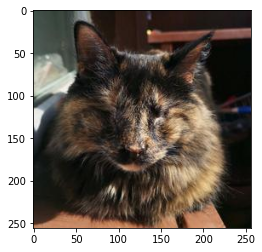

Dat is Лисена
Torchic thinks it is Лисена


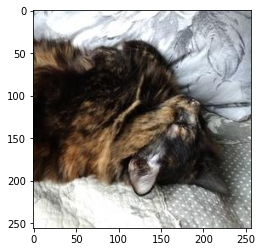

Dat is Лисена
Torchic thinks it is Лисена


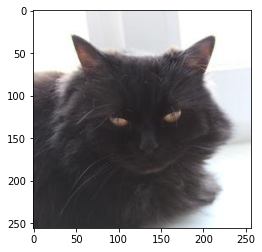

Dat is Мороша
Torchic thinks it is Мороша


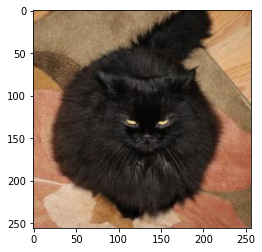

Dat is Мороша
Torchic thinks it is Мороша


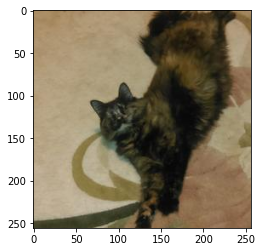

Dat is Лисена
Torchic thinks it is Лисена


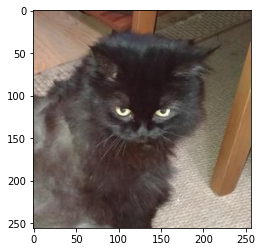

Dat is Мороша
Torchic thinks it is Мороша


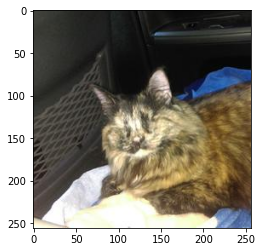

Dat is Лисена
Torchic thinks it is Лисена


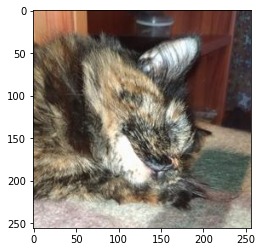

Dat is Лисена
Torchic thinks it is Лисена


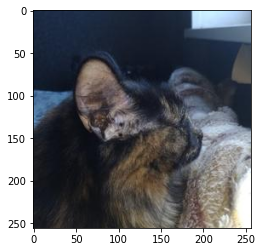

Dat is Лисена
Torchic thinks it is Мороша


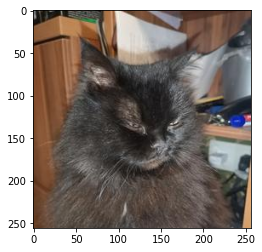

Dat is Мороша
Torchic thinks it is Мороша


In [46]:
classes = {0: 'Лисена', 1: 'Мороша'}

torchic.eval()
for i in range(10):
    plt.imshow(traintest['val'][i][0].permute(1, 2, 0))
    plt.show()
    print(f"Dat is {classes[traintest['val'][i][1]]}")
    ypred = torchic(traintest['val'][i][0].unsqueeze(1).permute(1, 0, 2, 3))
    print(f"Torchic thinks it is {classes[torch.argmax(ypred, dim=-1).item()]}")